In [1]:
import os, re, glob, cv2, csv
import numpy as np
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import tifffile as tiff
import scipy as sp
from scipy import ndimage, io as sio
from scipy.ndimage import maximum_filter, label, find_objects
from scipy.stats import chi2, lognorm, poisson, norm
from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from natsort import natsorted
import trackpy as tp
import pandas as pd
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
import matplotlib.colors as mcolors
from tqdm import tqdm
from IPython.display import display, Image

# Set up matplotlib for animations
rc('animation', html='jshtml')

# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # ignore warnings for specific matplotlib commands which will be outdated soon


In [2]:
data_folder = 'E:\\Spandan\\2D_Neurons_Paper\\Glass\\div11\\control_2019_02_11_CL+DIV7_Cort_timelapse5'

In [3]:
yo = pd.read_csv(data_folder+'\\tp_trajectories_final.csv')

In [4]:
yo

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,...,y_start,x_end,y_end,frame_start,frame_end,distance,avg_velocity,sinuosity,track_length,track_duration
0,0,421.885993,264.381107,10.328084,1.129988,0.437686,2.052160,43.587176,0.002282,0,...,421.885993,264.262222,421.777778,0,15,0.160762,0.012366,80.992924,13.020566,13
1,1,278.354839,301.011290,6.022996,1.143706,0.196584,1.156027,29.540847,0.001347,1,...,278.354839,300.863636,278.284512,1,15,0.163547,0.013629,106.483071,17.414970,12
2,2,282.969283,302.218430,5.678018,1.235151,0.158974,0.930187,26.340714,0.002247,2,...,278.354839,300.863636,278.284512,1,15,0.163547,0.013629,106.483071,17.414970,12
3,3,421.995305,265.183099,4.127706,1.229527,0.525745,0.736398,22.474635,0.002634,2,...,421.885993,264.262222,421.777778,0,15,0.160762,0.012366,80.992924,13.020566,13
4,4,280.977083,301.772917,5.734705,1.289380,0.239233,0.884100,29.145845,0.001516,3,...,278.354839,300.863636,278.284512,1,15,0.163547,0.013629,106.483071,17.414970,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,1000,101.897081,87.204301,13.257079,1.297522,0.181626,1.853140,72.481251,0.000985,376,...,99.851456,86.701493,104.117271,363,378,4.277501,0.356458,4.318462,18.472226,12
1001,1001,475.742690,188.429825,12.748422,1.154701,0.452906,2.497498,61.542959,0.001497,377,...,475.939759,189.452261,478.758794,362,378,2.986792,0.229753,5.234304,15.633780,13
1002,1002,101.093750,86.944712,7.753426,1.315587,0.116070,1.043730,43.934393,0.002097,377,...,99.851456,86.701493,104.117271,363,378,4.277501,0.356458,4.318462,18.472226,12
1003,1003,478.758794,189.452261,15.051484,1.231904,0.044391,2.647246,91.120628,0.002498,378,...,475.939759,189.452261,478.758794,362,378,2.986792,0.229753,5.234304,15.633780,13


(array([207.,  77., 179., 154., 141.,  61.,  21.,  42.,  42.,   0.,  25.,
         21.,  13.,   0.,  22.]),
 array([ 0.15064768,  1.1203199 ,  2.08999212,  3.05966434,  4.02933655,
         4.99900877,  5.96868099,  6.93835321,  7.90802542,  8.87769764,
         9.84736986, 10.81704208, 11.78671429, 12.75638651, 13.72605873,
        14.69573094]),
 <BarContainer object of 15 artists>)

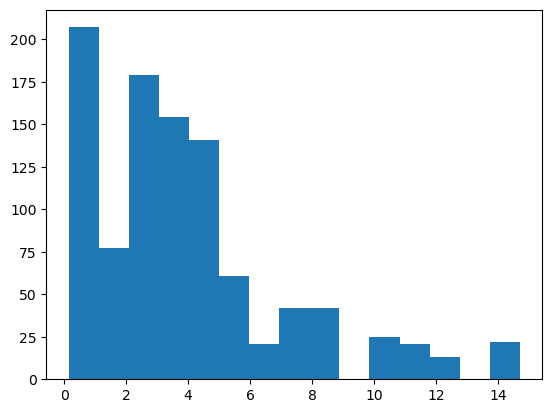

In [27]:
plt.hist(yo['distance'],bins=15)

(array([ 53., 112., 130., 165., 130.,  63.,  98., 119.,  40.,  23.,  11.,
          0.,  36.,   0.,  25.]),
 array([10.70699495, 13.36129242, 16.01558988, 18.66988735, 21.32418482,
        23.97848229, 26.63277975, 29.28707722, 31.94137469, 34.59567215,
        37.24996962, 39.90426709, 42.55856456, 45.21286202, 47.86715949,
        50.52145696]),
 <BarContainer object of 15 artists>)

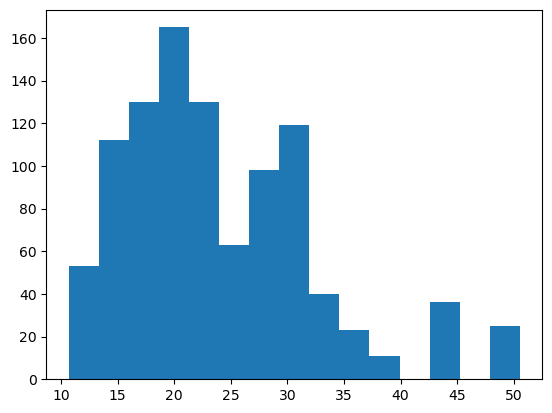

In [26]:
plt.hist(yo['track_length'],bins=15)

(array([290., 165., 132., 104., 126.,  60.,  32.,  34.,  18.,  19.,   0.,
          0.,   0.,   0.,  25.]),
 array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
        23., 24., 25.]),
 <BarContainer object of 15 artists>)

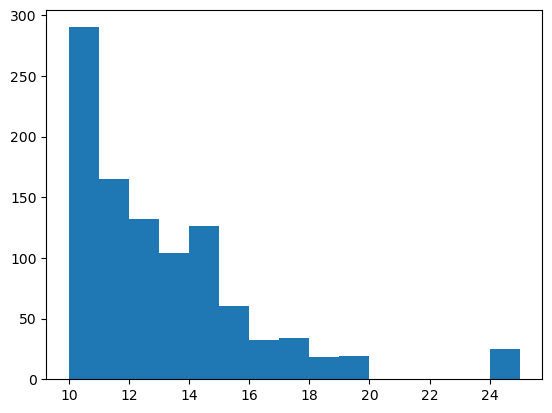

In [28]:
plt.hist(yo['track_duration'],bins=15)

(array([157.,  86., 112.,  77., 121.,  99., 161., 106.,  34.,  31.,   0.,
          0.,  11.,   0.,  10.]),
 array([0.94098319, 1.10376085, 1.26653851, 1.42931617, 1.59209383,
        1.75487149, 1.91764915, 2.08042681, 2.24320447, 2.40598213,
        2.56875979, 2.73153745, 2.89431511, 3.05709277, 3.21987043,
        3.38264809]),
 <BarContainer object of 15 artists>)

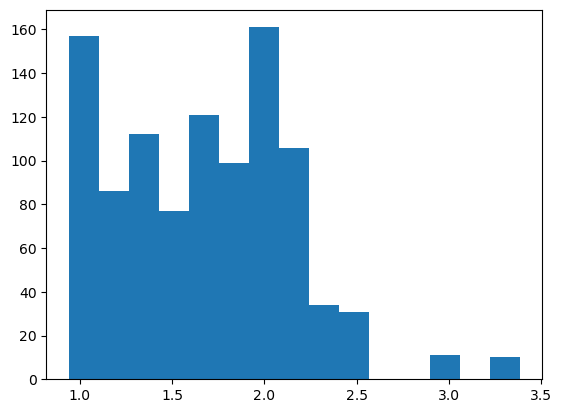

In [38]:
plt.hist(yo['avg_inst_velocity'],bins=15)